<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_STE_3pulses_5echoes_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pypulseq &> /dev/null
!pip install  torchkbnufft --no-deps
!pip install MRzeroCore --no-deps
!pip install pydisseqt
!pip install ismrmrd

!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

In [8]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import matplotlib.pyplot as plt
import torch

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

(STE_3pulses_5echoes_seq)=
# STE in a brain phantom

In [5]:
def seq_STE(
    fov=(220e-3, 220e-3, 8e-3),
    Nread=96,
    Nphase=96,
    Npart=1,
    FA=None,          # flip angle tensor (for 1st and 2nd RF)
    FA_ref=None,      # refocusing flip angle tensor (for 3rd RF)
    slice_thickness=8e-3,
    bw=None,          # bandwidth
    experiment_id="STE",
    system=None,
    delta_1st2ndRF=20e-3
):
    """
    Generate a STE (Stimulated Echo) sequence with 3 RF pulses and 5 echoes following the MRzero standard.
    
    Args:
        fov: tuple of floats (x, y, z) in meters
        Nread: int - frequency encoding steps
        Nphase: int - phase encoding steps
        Npart: int - number of partitions
        FA: tensor - flip angle for 1st and 2nd RF pulses
        FA_ref: tensor - refocusing flip angle for 3rd RF pulse
        slice_thickness: float - slice thickness in meters
        bw: int - bandwidth
        experiment_id: string - experiment identifier
        system: optional scanner system limits
    
    Returns:
        pp.Sequence: Pulseq sequence object
    """
    
    # Use default system if none provided
    if system is None:
        system = pp.Opts(
            max_grad=28, grad_unit='mT/m',
            max_slew=150, slew_unit='T/m/s',
            rf_ringdown_time=20e-6,
            rf_dead_time=100e-6,
            adc_dead_time=20e-6,
            grad_raster_time=10e-6
        )
    
    # Create sequence
    seq = pp.Sequence()
    
    # Set sequence definitions according to standard
    seq.set_definition('name', experiment_id)
    seq.set_definition('fov', [fov[0], fov[1], fov[2]])
    seq.set_definition('matrix', [Nread, Nphase, Npart])
    
    # Extract parameters
    fov_x, fov_y, slice_thickness = fov
    
    # Use provided FA or defaults
    if FA is not None:
        flip_angle_1st2nd = FA.item() if hasattr(FA, 'item') else FA
    else:
        flip_angle_1st2nd = 90 * np.pi / 180  # default 90 degrees
        
    if FA_ref is not None:
        flip_angle_3rd = FA_ref.item() if hasattr(FA_ref, 'item') else FA_ref
    else:
        flip_angle_3rd = 180 * np.pi / 180  # default 180 degrees
    
    # Calculate dwell time based on bandwidth if provided
    if bw is not None:
        dwell_time = 1 / bw
    else:
        dwell_time = 1e-4  # default
    
    # Define RF events
    rf1, _, _ = pp.make_sinc_pulse(
        flip_angle=flip_angle_1st2nd,
        duration=1e-3,
        phase_offset=90 * np.pi / 180,  # 90° phase offset for first RF
        slice_thickness=slice_thickness,
        apodization=0.5,
        time_bw_product=4,
        system=system,
        return_gz=True
    )
    
    rf2, _, _ = pp.make_sinc_pulse(
        flip_angle=flip_angle_1st2nd,
        duration=1e-3,
        slice_thickness=slice_thickness,
        apodization=0.5,
        time_bw_product=4,
        system=system,
        return_gz=True
    )
    
    rf3, _, _ = pp.make_sinc_pulse(
        flip_angle=flip_angle_3rd,
        duration=1e-3,
        slice_thickness=slice_thickness,
        apodization=0.5,
        time_bw_product=4,
        system=system,
        return_gz=True
    )
    
    
    # Calculate ADC raster duration according to system constraints
    a = int(system.adc_raster_time * Nread * 10**7)
    b = int(system.grad_raster_time * 10**7)
    c = int(delta_1st2ndRF * 10**7)
    lcm_ab = abs(a * b) // np.gcd(a, b)
    adc_raster_duration = (lcm_ab if round(c / lcm_ab) == 0 else round(c / lcm_ab) * lcm_ab) / 10**7
    
    # Define ADC events
    adc1 = pp.make_adc(
        num_samples=Nread,
        duration=adc_raster_duration,
        phase_offset=0,
        system=system
    )
    
    adc2 = pp.make_adc(
        num_samples=Nread,
        duration=adc_raster_duration * 2,
        phase_offset=0,
        system=system
    )
    
    # Define gradients
    gx = pp.make_trapezoid(
        channel='x',
        flat_area=Nread / fov_x,
        flat_time=200e-3,
        system=system
    )
    
    gx_pre = pp.make_trapezoid(
        channel='x',
        area=-gx.area / 2,
        duration=1e-3,
        system=system
    )
    
    gspoil = pp.make_trapezoid(
        channel='x',
        area=1000,
        duration=5e-3,
        system=system
    )

    # ======
    # CONSTRUCT SEQUENCE
    # ======
    seq.add_block(rf1)
    seq.add_block(adc1)
    seq.add_block(pp.make_delay(0.005))
    seq.add_block(rf2)
    seq.add_block(adc2)
    seq.add_block(rf3)
    seq.add_block(adc2)
    seq.add_block(adc2)

    seq.write(experiment_id + ".seq")

    return seq

C:\Users\alyar\AppData\Local\Temp\ipykernel_9308\74033948.py:73: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf1, _, _ = pp.make_sinc_pulse(
C:\Users\alyar\AppData\Local\Temp\ipykernel_9308\74033948.py:84: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf2, _, _ = pp.make_sinc_pulse(
C:\Users\alyar\AppData\Local\Temp\ipykernel_9308\74033948.py:94: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf3, _, _ = pp.make_sinc_pulse(
C:\Users\alyar\AppData\Local\Temp\ipykernel_9308\74033948.py:113: UserWarning: Specified ADC delay 0.00 us is less than the dead time 20 us. Delay was increased to the dead time.
  adc1 = pp.make_adc(
C:\Users\alyar\AppData\Local\Temp\ipykernel_9308\74033948.py:120: UserWarning: Specified ADC delay 0.00 us is less than the dead time 20 us. Delay was increased to

DEPRECATED: util.simulate_2d will be removed in the future.
Use util.simulate() instead (together with util.load_phantom() if necessary
Calculating repetition 3 / 3 - done


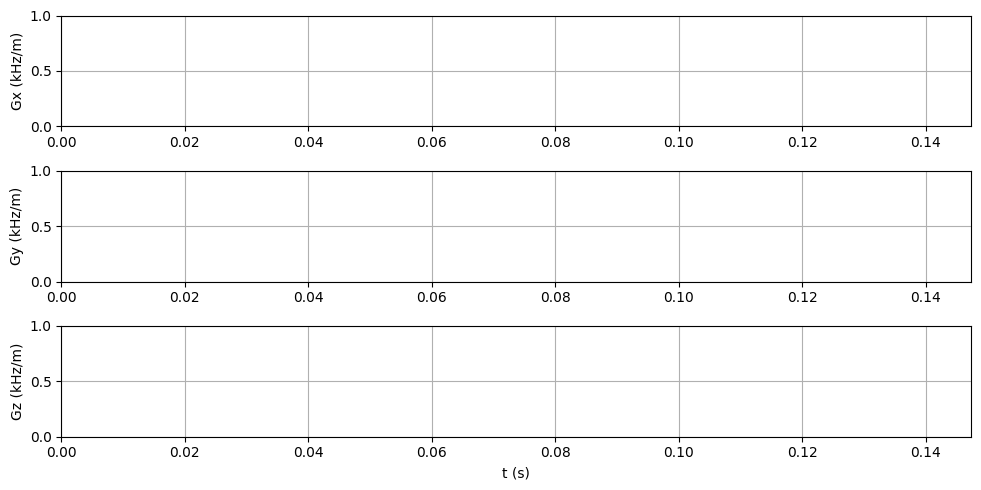

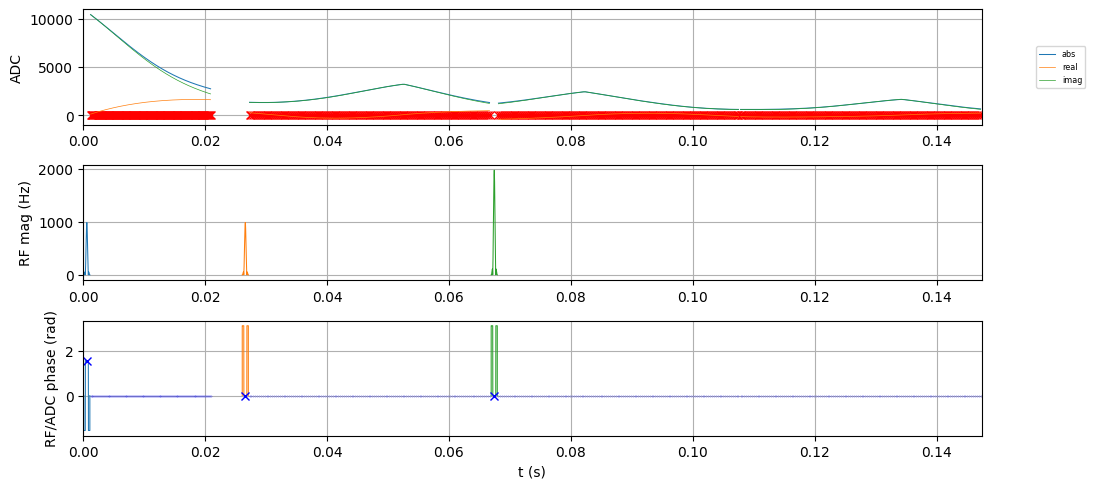

In [9]:
# Define seq parameters
fov = (200e-3, 200e-3, 8e-3)
Nread = 128
Nphase = 1

# Define rf events
angle_1st2ndRF=90#@param {type:'slider', title:"1st-2nd RFs flip angle",min:0,max:90,step:10}
angle_3rdRF=180#@param {type:'slider', title:"3rd RF flip angle",min:90,max:180,step:5}
delta_1st2ndRF=20e-3 #@param {type:'slider', title:"1st-2nd RFs delta time",min:10e-3,max:50e-3,step:5e-3}


# Generate sequence using standard parameters
seq = seq_STE(
    fov=fov,
    Nread=Nread,
    Nphase=Nphase,
    FA=torch.tensor(angle_1st2ndRF * np.pi / 180),
    FA_ref=torch.tensor(angle_3rdRF * np.pi / 180),
    experiment_id='STE',
    delta_1st2ndRF = delta_1st2ndRF
)

#@title quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq,)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

In [7]:
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

Timing check passed successfully
